This notebook is used to analyze training results. In order to get training results first, do the following:

* train networks by runnnig "python kepler_cv_blocksize.py"
* be sure to change to your sweeping parameters in the main() function of kepler_cv_blocksize.py
* results are saved in the folder "./results/kepler_cv_blocksize(_seed_xx)"

Note our terminology: block size = context length

Text(0.5, 1.0, 'losses')

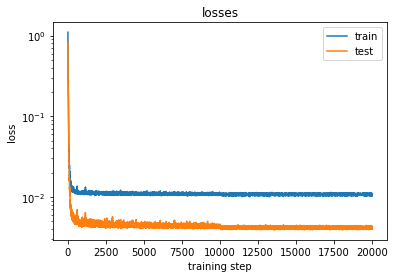

In [37]:
import matplotlib.pyplot as plt
import numpy as np

seed = 1
num_traj = 10000
noise_scale = 0.1
n_embd = 32
n_layer = 2
n_head = 1
block_size = 2
loss_mask = 'all'

f'./results/kepler_cv_blocksize/results_block_size_{block_size}_num_trajectories_{num_traj}_noise_scale_{noise_scale}_loss_mask_{loss_mask}.npz'

# load results from ./results/kepler_cv/results_seed_1_num_trajectories_1000_noise_scale_0.1_n_embd_16_n_layer_2_n_head_1.npz
loaded = np.load(f'./results/kepler_cv_blocksize/results_block_size_{block_size}_num_trajectories_{num_traj}_noise_scale_{noise_scale}_loss_mask_{loss_mask}.npz', allow_pickle=True)
#loaded = np.load(f'./results/kepler_cv_blocksize/results_block_size_{block_size}_num_trajectories_{num_traj}_noise_scale_{noise_scale}_loss_mask_{loss_mask}_seed_2.npz', allow_pickle=True)
loaded_results = {key: loaded[key] for key in loaded.keys()}

plt.plot(loaded_results['train_losses'])
plt.plot(loaded_results['test_losses'])
#plt.xscale('log')
plt.yscale('log')

plt.xlabel('training step')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.title('losses')


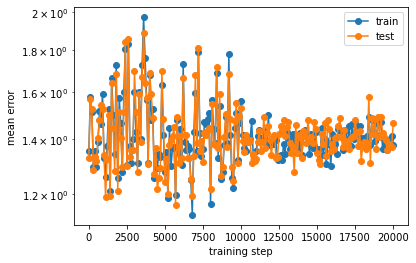

In [38]:
mean_errors_train = []
mean_errors_test = []
eval_steps = []
for i in range(len(loaded_results['eval_results'])):
    mean_errors_train.append(loaded_results['eval_results'][i]['error_stats_train']['mean_error'])
    mean_errors_test.append(loaded_results['eval_results'][i]['error_stats_test']['mean_error'])
    eval_steps.append(loaded_results['eval_steps'][i])

plt.plot(eval_steps, mean_errors_train, marker='o')
plt.plot(eval_steps, mean_errors_test, marker='o')
#plt.xscale('log')
plt.yscale('log')
plt.ylabel('mean error')
plt.xlabel('training step')
plt.legend(['train', 'test'])


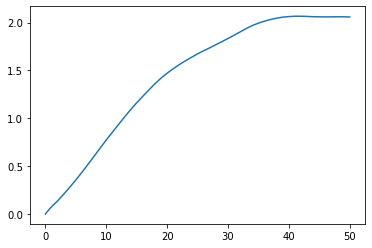

In [39]:
errors = loaded_results['eval_results'][i]['error_stats_test']['position_errors']
errors = np.insert(errors, 0, 0.)
plt.plot(errors)

In [40]:
loaded_results['eval_results'][-1]['probe_results']

{'input_embed': {'F_magnitude': {'r2': 0.00013377205245079793,
   'r2_last': 0.00017690452828122982},
  'F_direction_x': {'r2': 0.8380880532799431, 'r2_last': 0.8372016791760609},
  'F_direction_y': {'r2': 0.8306586884612832, 'r2_last': 0.8313805034647723},
  'Fx': {'r2': 0.12594727363762148, 'r2_last': 0.12339670738732744},
  'Fy': {'r2': 0.10728003594539981, 'r2_last': 0.13253306315244107},
  'r': {'r2': 0.00042305220607352645, 'r2_last': 0.0005204350347735032},
  'inv_r': {'r2': 0.0002098289035108447, 'r2_last': 0.00026026029208892076},
  'r_squared': {'r2': 0.00045141974176021726,
   'r2_last': 0.0005179778784741851},
  'inv_r_squared': {'r2': 0.00013377560465499538,
   'r2_last': 0.000176906563081336},
  'inv_r_cubed': {'r2': 8.876309578365049e-05,
   'r2_last': 0.00014403929604045462},
  'x': {'r2': 0.9999999999999946, 'r2_last': 0.9999999999999922},
  'y': {'r2': 0.9999999999999752, 'r2_last': 0.99999999999999}},
 'after_pos_emb': {'F_magnitude': {'r2': 0.00018855048383170647,
 

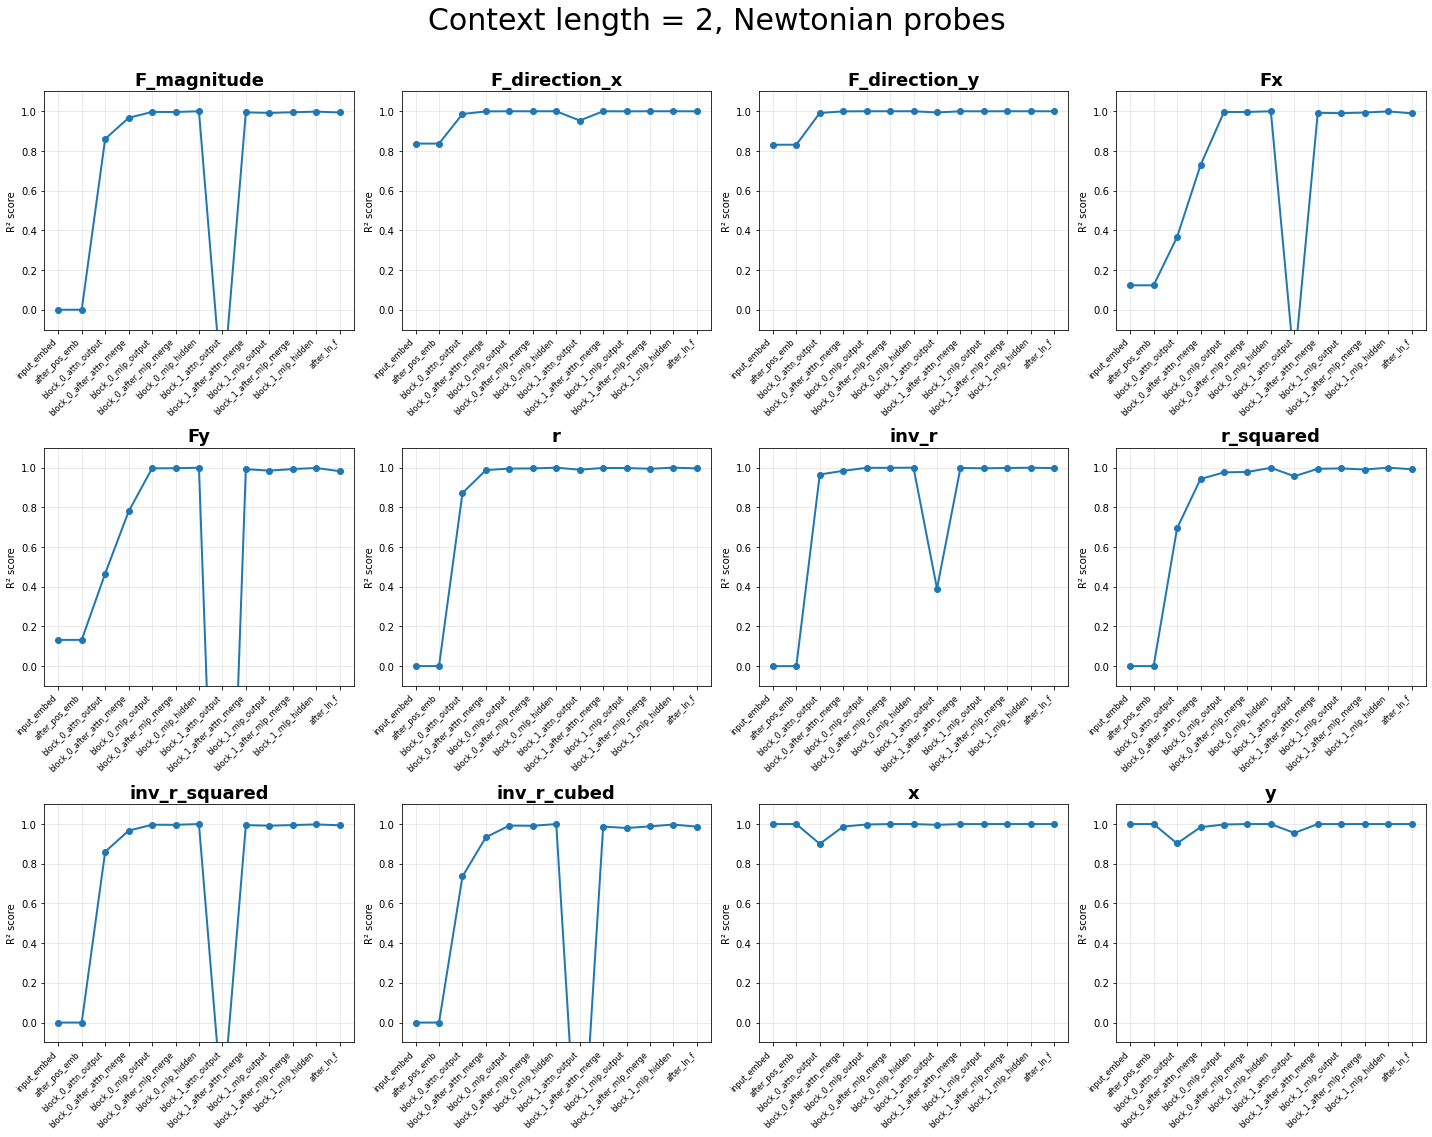

In [41]:
# Extract probe results from the last evaluation
probe_results = loaded_results['eval_results'][-1]['probe_results']

# Define the layer order for plotting
layer_order = [
    'input_embed',
    'after_pos_emb',
]

# Add block layers in order
n_layer = n_layer
for block_idx in range(n_layer):
    layer_order.extend([
        f'block_{block_idx}_attn_output',
        f'block_{block_idx}_after_attn_merge',
        f'block_{block_idx}_mlp_output',
        f'block_{block_idx}_after_mlp_merge',
        f'block_{block_idx}_mlp_hidden',
    ])

layer_order.append('after_ln_f')

# Filter layer_order to only include layers that exist in probe_results
available_layers = [layer for layer in layer_order if layer in probe_results]

# Define target variables to plot
target_variables = [
    'F_magnitude',
    'F_direction_x',
    'F_direction_y',
    'Fx',
    'Fy',
    'r',
    'inv_r',
    'r_squared',
    'inv_r_squared',
    'inv_r_cubed',
    'x',
    'y'
]

# Create plots for each target variable
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

postfix = '_last'

for idx, target_var in enumerate(target_variables):
    ax = axes[idx]
    
    # Extract R² scores for this target variable across all layers
    r2_scores = []
    layer_names = []
    
    for layer in available_layers:
        if layer in probe_results and target_var in probe_results[layer]:
            r2_scores.append(probe_results[layer][target_var]['r2'+postfix])
            layer_names.append(layer)
    
    # Plot
    if len(r2_scores) > 0:
        x_positions = range(len(layer_names))
        ax.plot(x_positions, r2_scores, 'o-', linewidth=2, markersize=6)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(layer_names, rotation=45, ha='right', fontsize=8)
        ax.set_ylabel('R² score', fontsize=10)
        ax.set_title(f'{target_var}', fontsize=18, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim([-0.1, 1.1])
    else:
        ax.text(0.5, 0.5, f'No data for {target_var}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{target_var}', fontsize=12)

plt.tight_layout()

plt.suptitle(f'Context length = {block_size}, Newtonian probes', y=1.05, fontsize=30)
plt.savefig(f'./plots/force_probes_block_size_{block_size}.png', dpi=300, bbox_inches='tight')
plt.show()


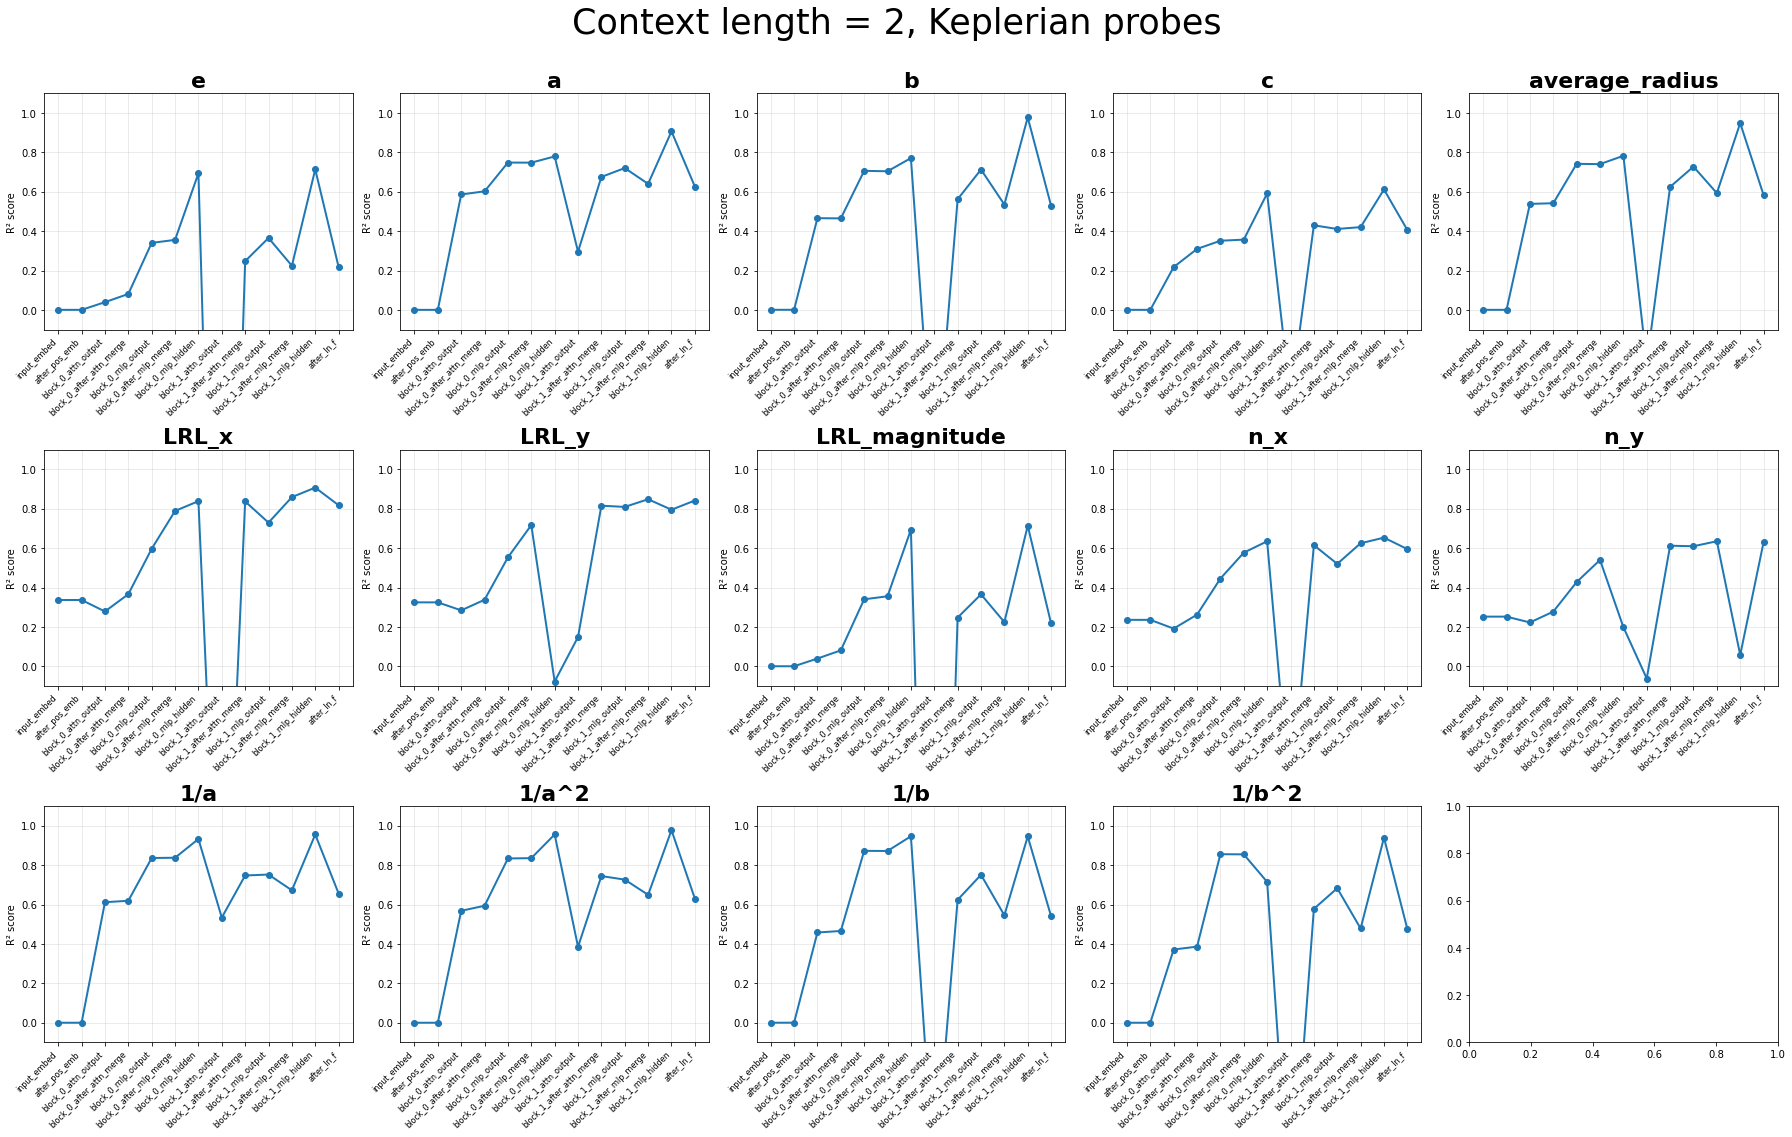

In [42]:
# Extract geometry probe results from the last evaluation
geometry_probe_results = loaded_results['eval_results'][-1]['geometry_probe_results']

postfix = '_last'

# Check if geometry probe results exist
if geometry_probe_results is not None:
    # Define the layer order for plotting
    layer_order = [
        'input_embed',
        'after_pos_emb',
    ]
    
    # Add block layers in order
    for block_idx in range(n_layer):
        layer_order.extend([
            f'block_{block_idx}_attn_output',
            f'block_{block_idx}_after_attn_merge',
            f'block_{block_idx}_mlp_output',
            f'block_{block_idx}_after_mlp_merge',
            f'block_{block_idx}_mlp_hidden',
        ])
    
    layer_order.append('after_ln_f')
    
    # Filter layer_order to only include layers that exist in geometry_probe_results
    available_layers = [layer for layer in layer_order if layer in geometry_probe_results]
    
    # Define target variables to plot (geometry probe targets)
    target_variables = [
        'e',              # eccentricity
        'a',              # semi-major axis
        'b',              # semi-minor axis
        'c',              # linear eccentricity (e * a)
        'average_radius',  # sqrt(a*b)
        'LRL_x',
        'LRL_y',
        'LRL_magnitude',
        'n_x',
        'n_y',
        '1/a',
        '1/a^2',
        '1/b',
        '1/b^2'
    ]
    
    # Create plots for each target variable (1 row, 5 columns)
    fig, axes = plt.subplots(3, 5, figsize=(25, 15))
    axes = axes.flatten()
    
    for idx, target_var in enumerate(target_variables):
        ax = axes[idx]
        
        # Extract R² scores for this target variable across all layers
        r2_scores = []
        layer_names = []
        
        for layer in available_layers:
            if layer in geometry_probe_results and target_var in geometry_probe_results[layer]:
                r2_scores.append(geometry_probe_results[layer][target_var]['r2'+postfix])
                layer_names.append(layer)
        
        # Plot
        if len(r2_scores) > 0:
            x_positions = range(len(layer_names))
            ax.plot(x_positions, r2_scores, 'o-', linewidth=2, markersize=6)
            ax.set_xticks(x_positions)
            ax.set_xticklabels(layer_names, rotation=45, ha='right', fontsize=8)
            ax.set_ylabel('R² score', fontsize=10)
            ax.set_title(f'{target_var}', fontsize=22, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_ylim([-0.1, 1.1])
        else:
            ax.text(0.5, 0.5, f'No data for {target_var}', 
                    ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{target_var}', fontsize=15)
    
    plt.tight_layout()
    plt.suptitle(f'Context length = {block_size}, Keplerian probes', y=1.05, fontsize=35)
    plt.savefig(f'./plots/geometry_probes_block_size_{block_size}.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No geometry probe results found in the loaded results.")


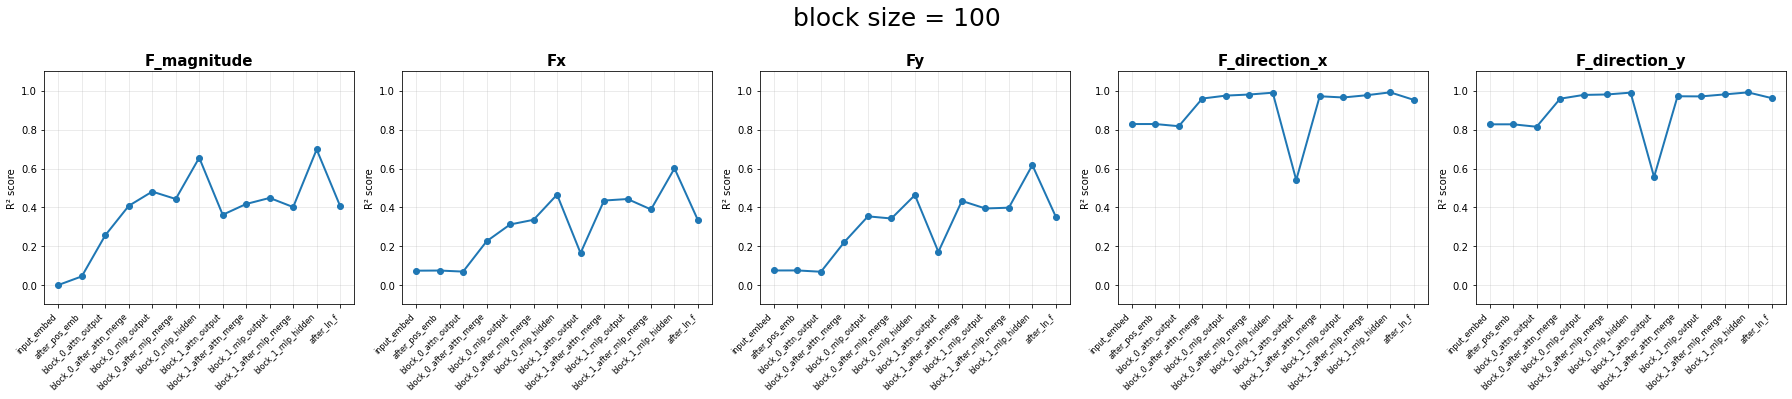

In [15]:
# Extract probe results from the last evaluation
probe_results = loaded_results['eval_results'][-1]['probe_results']

# Define the layer order for plotting
layer_order = [
    'input_embed',
    'after_pos_emb',
]

# Add block layers in order
n_layer = n_layer
for block_idx in range(n_layer):
    layer_order.extend([
        f'block_{block_idx}_attn_output',
        f'block_{block_idx}_after_attn_merge',
        f'block_{block_idx}_mlp_output',
        f'block_{block_idx}_after_mlp_merge',
        f'block_{block_idx}_mlp_hidden',
    ])

layer_order.append('after_ln_f')

# Filter layer_order to only include layers that exist in probe_results
available_layers = [layer for layer in layer_order if layer in probe_results]

# Define only the first 5 target variables to plot
target_variables = [
    'F_magnitude',
    'Fx',
    'Fy',
    'F_direction_x',
    'F_direction_y',
]

# Create plots in a single row (1x5)
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
axes = axes.flatten()

for idx, target_var in enumerate(target_variables):
    ax = axes[idx]
    
    # Extract R² scores for this target variable across all layers
    r2_scores = []
    layer_names = []
    
    for layer in available_layers:
        if layer in probe_results and target_var in probe_results[layer]:
            r2_scores.append(probe_results[layer][target_var]['r2'])
            layer_names.append(layer)
    
    # Plot
    if len(r2_scores) > 0:
        x_positions = range(len(layer_names))
        ax.plot(x_positions, r2_scores, 'o-', linewidth=2, markersize=6)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(layer_names, rotation=45, ha='right', fontsize=8)
        ax.set_ylabel('R² score', fontsize=10)
        ax.set_title(f'{target_var}', fontsize=15, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim([-0.1, 1.1])
    else:
        ax.text(0.5, 0.5, f'No data for {target_var}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{target_var}', fontsize=15)

plt.tight_layout()

plt.suptitle(f'block size = {block_size}', y=1.1, fontsize=25)
plt.savefig(f'./plots/emergence_of_gravity_block_size_{block_size}.png', dpi=300, bbox_inches='tight')

In [7]:
# Collect performance and R2 metrics for each block_size
import numpy as np
import os

block_sizes = [1, 2, 5, 10, 20, 50, 100]
num_traj = 10000
noise_scale = 0.1
loss_mask = 'all'

postfix = '_last'

# Storage for results
results_summary = {
    'block_sizes': [],
    'min_mean_errors_test': [],
    'best_r2_F_magnitude': [],
    'best_r2_Fx': [],
    'best_r2_Fy': [],
    'best_r2_a': [],
    'best_r2_e': [],
    'best_r2_b': [],
    'best_r2_c': [],
    'best_r2_average_radius': [],
    'best_r2_LRL_x': [],
    'best_r2_LRL_y': [],
    'best_r2_LRL_magnitude': [],
    'best_r2_n_x': [],
    'best_r2_n_y': [],
}

for block_size in block_sizes:
    if block_size == 100:
        results_file = f'./results/kepler_cv_blocksize/results_block_size_{block_size}_num_trajectories_{num_traj}_noise_scale_{noise_scale}_loss_mask_{loss_mask}.npz'
    else:
        results_file = f'./results/kepler_cv_blocksize/results_block_size_{block_size}_num_trajectories_{num_traj}_noise_scale_{noise_scale}_loss_mask_{loss_mask}.npz'
    
    if not os.path.exists(results_file):
        print(f"Warning: Results file not found for block_size={block_size}: {results_file}")
        continue
    
    # Load results
    loaded = np.load(results_file, allow_pickle=True)
    loaded_results = {key: loaded[key] for key in loaded.keys()}
    
    # Get minimum mean_errors_test across all evaluation steps
    min_mean_error = loaded_results['eval_results'][-1]['error_stats_test']['position_errors']
    
    # Get best R2 for F_magnitude, Fx, Fy across all layers
    probe_results = loaded_results['eval_results'][-1]['probe_results']
    geometry_probe_results = loaded_results['eval_results'][-1]['geometry_probe_results']
    
    # Find best R2 for each target variable across all layers
    best_r2_F_magnitude = -np.inf
    best_r2_Fx = -np.inf
    best_r2_Fy = -np.inf
    best_r2_a = -np.inf
    best_r2_e = -np.inf
    best_r2_b = -np.inf
    best_r2_c = -np.inf
    best_r2_average_radius = -np.inf
    best_r2_LRL_x = -np.inf
    best_r2_LRL_y = -np.inf
    best_r2_LRL_magnitude = -np.inf
    best_r2_n_x = -np.inf
    best_r2_n_y = -np.inf
    
    for layer_name, layer_results in probe_results.items():
        if 'F_magnitude' in layer_results:
            r2 = layer_results['F_magnitude']['r2'+postfix]
            if r2 > best_r2_F_magnitude:
                best_r2_F_magnitude = r2
        
        if 'Fx' in layer_results:
            r2 = layer_results['Fx']['r2'+postfix]
            if r2 > best_r2_Fx:
                best_r2_Fx = r2
        
        if 'Fy' in layer_results:
            r2 = layer_results['Fy']['r2'+postfix]
            if r2 > best_r2_Fy:
                best_r2_Fy = r2

    for layer_name, layer_results in geometry_probe_results.items():

        if 'a' in layer_results:
            r2 = layer_results['a']['r2'+postfix]
            if r2 > best_r2_a:
                best_r2_a = r2
        
        if 'e' in layer_results: 
            r2 = layer_results['e']['r2'+postfix]
            if r2 > best_r2_e:
                best_r2_e = r2
        
        if 'b' in layer_results:
            r2 = layer_results['b']['r2'+postfix]
            if r2 > best_r2_b:
                best_r2_b = r2
        
        if 'c' in layer_results:
            r2 = layer_results['c']['r2'+postfix]
            if r2 > best_r2_c:
                best_r2_c = r2
            
        if 'LRL_x' in layer_results:
            r2 = layer_results['LRL_x']['r2'+postfix]
            if r2 > best_r2_LRL_x:
                best_r2_LRL_x = r2
            
        if 'LRL_y' in layer_results:
            r2 = layer_results['LRL_y']['r2'+postfix]
            if r2 > best_r2_LRL_y:
                best_r2_LRL_y = r2
            
        if 'LRL_magnitude' in layer_results:
            r2 = layer_results['LRL_magnitude']['r2'+postfix]
            if r2 > best_r2_LRL_magnitude:
                best_r2_LRL_magnitude = r2
            
        if 'n_x' in layer_results:
            r2 = layer_results['n_x']['r2'+postfix]
            if r2 > best_r2_n_x:
                best_r2_n_x = r2
        
        if 'n_y' in layer_results:
            r2 = layer_results['n_y']['r2'+postfix]
            if r2 > best_r2_n_y:
                best_r2_n_y = r2
            
    
    # Store results
    results_summary['block_sizes'].append(block_size)
    results_summary['min_mean_errors_test'].append(min_mean_error)
    results_summary['best_r2_F_magnitude'].append(best_r2_F_magnitude)
    results_summary['best_r2_Fx'].append(best_r2_Fx)
    results_summary['best_r2_Fy'].append(best_r2_Fy)
    results_summary['best_r2_a'].append(best_r2_a)
    results_summary['best_r2_e'].append(best_r2_e)
    results_summary['best_r2_b'].append(best_r2_b)
    results_summary['best_r2_c'].append(best_r2_c)
    results_summary['best_r2_LRL_x'].append(best_r2_LRL_x)
    results_summary['best_r2_LRL_y'].append(best_r2_LRL_y)
    results_summary['best_r2_LRL_magnitude'].append(best_r2_LRL_magnitude)
    results_summary['best_r2_n_x'].append(best_r2_n_x)
    results_summary['best_r2_n_y'].append(best_r2_n_y)
    
    print(f"block_size={block_size:3d}: min_error={np.mean(min_mean_error):.6f}, "
          f"R2_F_mag={best_r2_F_magnitude:.4f}, R2_Fx={best_r2_Fx:.4f}, R2_Fy={best_r2_Fy:.4f}")

# Convert to numpy arrays for easier plotting
results_summary['block_sizes'] = np.array(results_summary['block_sizes'])
results_summary['min_mean_errors_test'] = np.array(results_summary['min_mean_errors_test'])
results_summary['best_r2_F_magnitude'] = np.array(results_summary['best_r2_F_magnitude'])
results_summary['best_r2_Fx'] = np.array(results_summary['best_r2_Fx'])
results_summary['best_r2_Fy'] = np.array(results_summary['best_r2_Fy'])
results_summary['best_r2_a'] = np.array(results_summary['best_r2_a'])
results_summary['best_r2_e'] = np.array(results_summary['best_r2_e'])
results_summary['best_r2_b'] = np.array(results_summary['best_r2_b'])
results_summary['best_r2_c'] = np.array(results_summary['best_r2_c'])
results_summary['best_r2_LRL_x'] = np.array(results_summary['best_r2_LRL_x'])
results_summary['best_r2_LRL_y'] = np.array(results_summary['best_r2_LRL_y'])
results_summary['best_r2_LRL_magnitude'] = np.array(results_summary['best_r2_LRL_magnitude'])
results_summary['best_r2_n_x'] = np.array(results_summary['best_r2_n_x'])
results_summary['best_r2_n_y'] = np.array(results_summary['best_r2_n_y'])

print("\nSummary:")
print(f"Block sizes: {results_summary['block_sizes']}")
print(f"Min errors: {results_summary['min_mean_errors_test']}")
print(f"Best R2 F_magnitude: {results_summary['best_r2_F_magnitude']}")
print(f"Best R2 Fx: {results_summary['best_r2_Fx']}")
print(f"Best R2 Fy: {results_summary['best_r2_Fy']}")


block_size=  1: min_error=1.250292, R2_F_mag=0.9999, R2_Fx=0.9998, R2_Fy=0.9995
block_size=  2: min_error=1.464218, R2_F_mag=1.0000, R2_Fx=0.9999, R2_Fy=0.9997
block_size=  5: min_error=1.264328, R2_F_mag=0.9985, R2_Fx=0.9942, R2_Fy=0.9952
block_size= 10: min_error=0.883271, R2_F_mag=0.9787, R2_Fx=0.9493, R2_Fy=0.9412
block_size= 20: min_error=0.252796, R2_F_mag=0.9572, R2_Fx=0.9264, R2_Fy=0.8963
block_size= 50: min_error=0.153420, R2_F_mag=0.9530, R2_Fx=0.9127, R2_Fy=0.8897
block_size=100: min_error=0.109168, R2_F_mag=0.9596, R2_Fx=0.9057, R2_Fy=0.9161

Summary:
Block sizes: [  1   2   5  10  20  50 100]
Min errors: [[0.05617141 0.11597048 0.18038717 0.24813019 0.3184614  0.39034483
  0.46254796 0.53577864 0.60768497 0.67695093 0.74336183 0.8089583
  0.8698235  0.927769   0.9825759  1.0343062  1.0837165  1.1316042
  1.1798306  1.2263626  1.2708509  1.3128132  1.3548973  1.3940479
  1.4307775  1.4642503  1.4942609  1.5217263  1.5457445  1.5675967
  1.5907764  1.6144162  1.6373608  1.65

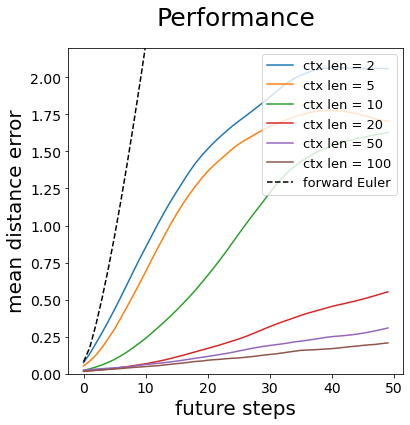

In [8]:
import matplotlib.pyplot as plt
import torch

plt.figure(figsize=(6, 6))

for i in range(1,results_summary['min_mean_errors_test'].shape[0]):
    plt.plot(results_summary['min_mean_errors_test'][i])
    
plt.xlabel('future steps', fontsize=20)
#plt.xscale('log')
plt.ylabel('mean distance error', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Performance', fontsize=25, y=1.05)
#plt.plot([2, 2], [0, 2], '--', color='black', linewidth=2)
plt.ylim(0, 2.2)

euler_errors = torch.load('data_cv/euler_error_chunk_000000.pt').detach().cpu().numpy()
plt.plot(euler_errors[1:51], ls='--', color='black')

plt.legend(['ctx len = 2', 'ctx len = 5', 'ctx len = 10', 'ctx len = 20', 'ctx len = 50', 'ctx len = 100', 'forward Euler'], fontsize=13, loc='upper right')
#plt.text(2.3, 0.58, "Newtonian mechanics (attention window = 2)", fontsize=13, ha='center', va='center', rotation=270)

plt.savefig('./plots/mean_distance_error_block_size.png', dpi=300, bbox_inches='tight')


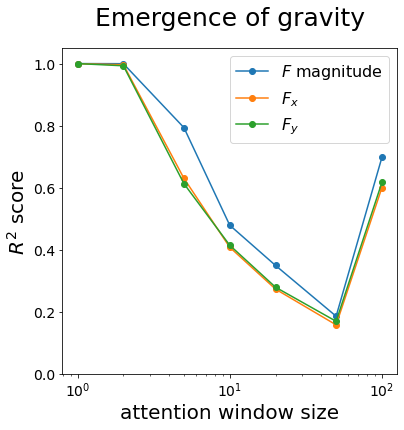

In [53]:
plt.figure(figsize=(6, 6))
plt.plot(results_summary['block_sizes'], results_summary['best_r2_F_magnitude'], marker='o')
plt.plot(results_summary['block_sizes'], results_summary['best_r2_Fx'], marker='o')
plt.plot(results_summary['block_sizes'], results_summary['best_r2_Fy'], marker='o')
plt.xlabel('attention window size', fontsize=20)
plt.xscale('log')
plt.ylabel(r'$R^2$ score', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.plot([2, 2], [0, 2], '--', color='black', linewidth=2)
#plt.text(2.3, 0.5, "Newtonian mechanics (attention window = 2)", fontsize=13, ha='center', va='center', rotation=270)
plt.ylim(0, 1.05)
plt.title('Emergence of gravity', fontsize=25, y=1.05)
plt.legend(['$F$ magnitude', '$F_x$', '$F_y$'], fontsize=16)
plt.savefig('./plots/emergence_of_gravity_block_size.png', dpi=300, bbox_inches='tight')

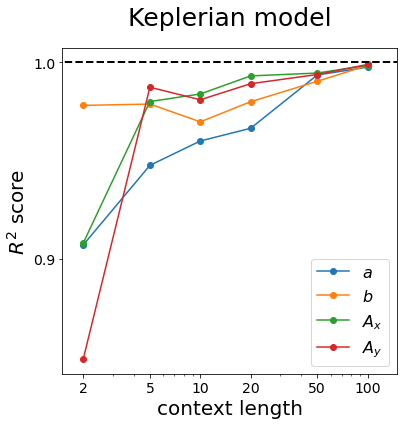

In [49]:
plt.figure(figsize=(6, 6))
plt.plot(results_summary['block_sizes'][1:], results_summary['best_r2_a'][1:], marker='o')
plt.plot(results_summary['block_sizes'][1:], results_summary['best_r2_b'][1:], marker='o')
plt.plot(results_summary['block_sizes'][1:], results_summary['best_r2_LRL_x'][1:], marker='o')
plt.plot(results_summary['block_sizes'][1:], results_summary['best_r2_LRL_y'][1:], marker='o')

#plt.plot(results_summary['block_sizes'][1:], results_summary['best_r2_c'][1:], marker='o')
#plt.plot(results_summary['block_sizes'][1:], results_summary['best_r2_e'][1:], marker='o')
plt.xlabel('context length', fontsize=20)
plt.xscale('log')
plt.ylabel(r'$R^2$ score', fontsize=20)
plt.xticks([2, 5, 10, 20, 50, 100], ['2', '5', '10', '20', '50', '100'], fontsize=14)
plt.yticks([0.8, 0.9, 1.0], fontsize=14)
#plt.plot([2, 2], [0, 2], '--', color='black', linewidth=2)
#plt.text(2.3, 0.5, "Newtonian mechanics (attention window = 2)", fontsize=13, ha='center', va='center', rotation=270)
plt.plot([1,200], [1,1], '--', color='black', linewidth=2)
plt.xlim(1.5, 150)
plt.title('Keplerian model', fontsize=25, y=1.05)
plt.legend(['$a$', '$b$', '$A_x$', '$A_y$'], fontsize=16, loc='lower right')
plt.savefig('./plots/app2/kepler_context_length.png', dpi=300, bbox_inches='tight')

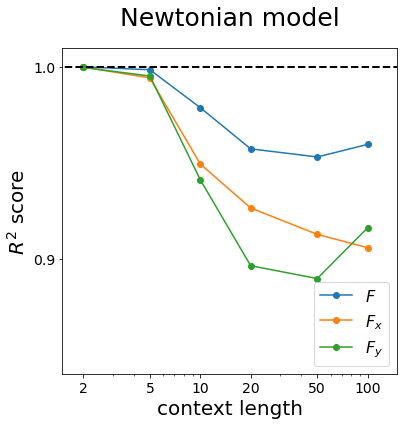

In [50]:
plt.figure(figsize=(6, 6))
plt.plot(results_summary['block_sizes'][1:], results_summary['best_r2_F_magnitude'][1:], marker='o')
plt.plot(results_summary['block_sizes'][1:], results_summary['best_r2_Fx'][1:], marker='o')
plt.plot(results_summary['block_sizes'][1:], results_summary['best_r2_Fy'][1:], marker='o')

#plt.plot(results_summary['block_sizes'][1:], results_summary['best_r2_c'][1:], marker='o')
#plt.plot(results_summary['block_sizes'][1:], results_summary['best_r2_e'][1:], marker='o')
plt.xlabel('context length', fontsize=20)
plt.xscale('log')
plt.ylabel(r'$R^2$ score', fontsize=20)
plt.xticks([2, 5, 10, 20, 50, 100], ['2', '5', '10', '20', '50', '100'], fontsize=14)
plt.yticks([0.8, 0.9, 1.0], fontsize=14)
#plt.plot([2, 2], [0, 2], '--', color='black', linewidth=2)
#plt.text(2.3, 0.5, "Newtonian mechanics (attention window = 2)", fontsize=13, ha='center', va='center', rotation=270)
plt.ylim(0.84, 1.01)
plt.plot([1,200], [1,1], '--', color='black', linewidth=2)
plt.xlim(1.5, 150)
plt.title('Newtonian model', fontsize=25, y=1.05)
plt.legend(['$F$', '$F_x$', '$F_y$'], fontsize=16, loc='lower right')
#plt.savefig('./plots/emergence_of_ellipse_block_size.png', dpi=300, bbox_inches='tight')
plt.savefig('./plots/app2/newton_context_length.png', dpi=300, bbox_inches='tight')

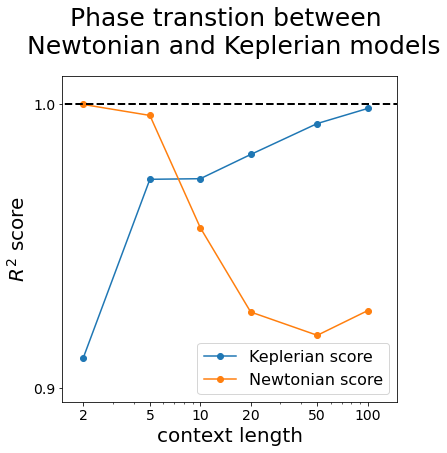

In [14]:
plt.figure(figsize=(6, 6))

Kepler_score = (results_summary['best_r2_a'][1:] + results_summary['best_r2_b'][1:] + results_summary['best_r2_LRL_x'][1:] + results_summary['best_r2_LRL_y'][1:])/4
Newton_score = (results_summary['best_r2_F_magnitude'][1:] + results_summary['best_r2_Fx'][1:] + results_summary['best_r2_Fy'][1:])/3
plt.plot(results_summary['block_sizes'][1:], Kepler_score, marker='o')
plt.plot(results_summary['block_sizes'][1:], Newton_score, marker='o')
plt.xlabel('context length', fontsize=20)
plt.xscale('log')
plt.xticks([2, 5, 10, 20, 50, 100], ['2', '5', '10', '20', '50', '100'], fontsize=14)
plt.yticks([0.9, 1.0], fontsize=14)

plt.legend(['Keplerian score', 'Newtonian score'], fontsize=16, loc='lower right')
plt.ylabel(r'$R^2$ score', fontsize=20)

plt.plot([1,200], [1,1], '--', color='black', linewidth=2)
plt.xlim(1.5, 150)
plt.ylim(0.895, 1.01)
#plt.savefig('./plots/world_modelness_block_size.png', dpi=300, bbox_inches='tight')

plt.title('Phase transtion between \n Newtonian and Keplerian models', fontsize=25, y=1.05)

plt.savefig('./plots/app2/kepler_newton_context_length.png', dpi=300, bbox_inches='tight')

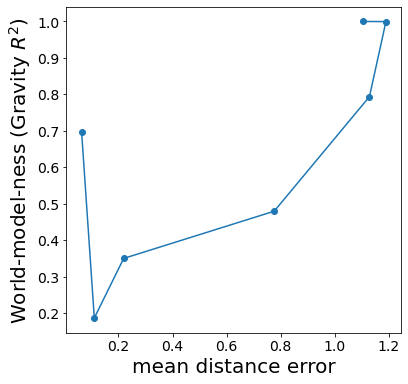

In [55]:
plt.figure(figsize=(6, 6))
plt.plot(results_summary['min_mean_errors_test'], results_summary['best_r2_F_magnitude'], marker='o')
plt.xlabel('mean distance error', fontsize=20)

plt.ylabel(r'World-model-ness (Gravity $R^2$)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('./plots/world_modelness_performance_tradeoff.png', dpi=300, bbox_inches='tight')

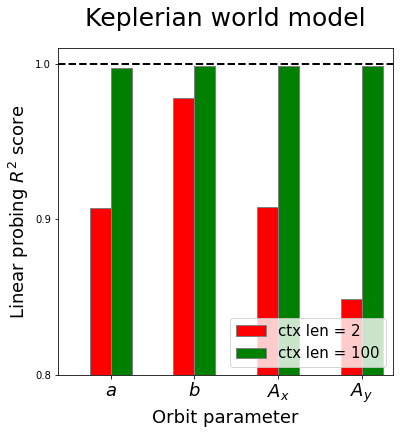

In [11]:
baseline_idx = 1

a = results_summary['best_r2_a'][[baseline_idx,-1]]
b = results_summary['best_r2_b'][[baseline_idx,-1]]
c = results_summary['best_r2_c'][[baseline_idx,-1]]
e = results_summary['best_r2_e'][[baseline_idx,-1]]
A_x = results_summary['best_r2_LRL_x'][[baseline_idx,-1]]
A_y = results_summary['best_r2_LRL_y'][[baseline_idx,-1]]
n_x = results_summary['best_r2_n_x'][[baseline_idx,-1]]
n_y = results_summary['best_r2_n_y'][[baseline_idx,-1]]

#block_2 = [a[0], b[0], c[0], e[0], A_x[0], A_y[0], n_x[0], n_y[0]]
#block_100 = [a[-1], b[-1], c[-1], e[-1], A_x[-1], A_y[-1], n_x[-1], n_y[-1]]
block_2 = [a[0], b[0], A_x[0], A_y[0]]
block_100 = [a[-1], b[-1], A_x[-1], A_y[-1]]

import matplotlib.pyplot as plt 

barWidth = 0.25
fig = plt.subplots(figsize =(6, 6)) 

br1 = np.arange(4)
br2 = [x + barWidth for x in br1] 

plt.bar(br1, block_2, color ='r', width = barWidth, 
        edgecolor ='grey', label ='block_2') 
plt.bar(br2, block_100, color ='g', width = barWidth, 
        edgecolor ='grey', label ='block_100') 

plt.legend(['ctx len = 2', 'ctx len = 100'], fontsize=15, loc='lower right')

plt.plot([-0.5,3.5], [1,1], '--', color='black', linewidth=2)

plt.xlim(-0.5,3.5)

plt.xlabel('Orbit parameter',fontsize = 18) 
plt.ylabel('Linear probing $R^2$ score',fontsize = 18) 
plt.xticks([r + 0.5*barWidth for r in range(4)], [r'$a$', r'$b$', r'$A_x$', r'$A_y$'], fontsize=18)
plt.ylim(0.8,1.01)
plt.yticks([0.8,0.9,1.0])
plt.title('Keplerian world model', fontsize=25, y=1.05)
plt.savefig('./plots/kepler_world_model_block_size.png', dpi=300, bbox_inches='tight')


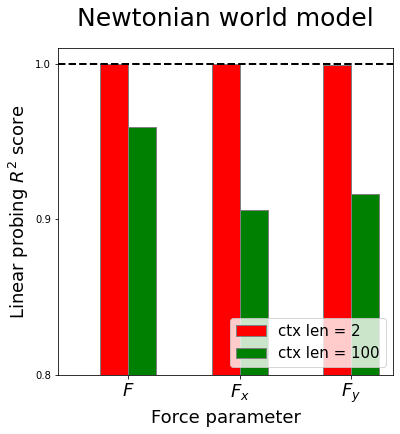

In [12]:
F = results_summary['best_r2_F_magnitude'][[1,-1]]
Fx = results_summary['best_r2_Fx'][[1,-1]]
Fy = results_summary['best_r2_Fy'][[1,-1]]


block_2 = [F[0], Fx[0], Fy[0]]
block_100 = [F[-1], Fx[-1], Fy[-1]]

import matplotlib.pyplot as plt 

barWidth = 0.25
fig = plt.subplots(figsize =(6, 6)) 

br1 = np.arange(3)
br2 = [x + barWidth for x in br1] 

plt.bar(br1, block_2, color ='r', width = barWidth, 
        edgecolor ='grey', label ='block_2') 
plt.bar(br2, block_100, color ='g', width = barWidth, 
        edgecolor ='grey', label ='block_100') 

plt.legend(['ctx len = 2', 'ctx len = 100'], fontsize=15, loc='lower right')

plt.plot([-0.5,2.5], [1,1], '--', color='black', linewidth=2)


plt.xlim(-0.5,2.5)

plt.xlabel('Force parameter',fontsize = 18) 
plt.ylabel('Linear probing $R^2$ score',fontsize = 18) 
plt.xticks([r + 0.5*barWidth for r in range(3)], [r'$F$', r'$F_x$', r'$F_y$'], fontsize=18)
plt.ylim(0.8,1.01)
plt.yticks([0.8,0.9,1.0])
plt.title('Newtonian world model', fontsize=25, y=1.05)
plt.savefig('./plots/newton_world_model_block_size.png', dpi=300, bbox_inches='tight')
